##Import Packages

In [3]:
import tensorflow as tf

import pandas as pd
import numpy as np

#from numpy import asarray
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Concatenate, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from matplotlib import image
import matplotlib.pyplot as plt

import zipfile
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib as mpl


import os
#from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import uuid
from tqdm import tqdm
import shutil
import pickle
from tensorflow.keras.models import Model

# Load the dataset

In [3]:
from google.colab import auth
auth.authenticate_user()

project_id = 'dynamic-fulcrum-314308'
!gcloud config set project {project_id}

from google.colab import drive
drive.mount('/content/drive')

Updated property [core/project].
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


read the training/test triplets

In [4]:
train_triplets = pd.read_csv('/content/drive/MyDrive/ml_task4/train_triplets.txt', delim_whitespace=True, header=None, names =['anchor','positive','negative'])
test_triplets = pd.read_csv('/content/drive/MyDrive/ml_task4/test_triplets.txt', delim_whitespace=True, header=None, names =['anchor','positive','negative'])

unzip the food images

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/ml_task4/food.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

print('Extracted images on local drive.')

Extracted images on local drive.


#Generate resized images

In [4]:
img_path = r'/content/food'
image_resized_path = r'/content/food_res/img'
if not os.path.exists(image_resized_path):
  os.makedirs(image_resized_path)

img_height = 299
img_width = 299

##Skip if resized images already exist

resize all images to have the same size, use padding if necessary

In [ ]:
for img_name in tqdm(os.listdir(img_path)):
  if img_name.endswith('.jpg'):
    img = load_img(img_path + '/' + img_name)
    img = img_to_array(img)
    img = tf.image.resize_with_pad(img, img_height, img_width, antialias=True)
    img = array_to_img(img)
    img.save(image_resized_path + '/' + img_name)

print('Resized images and saved to new directory.')

100%|██████████| 10001/10001 [02:55<00:00, 57.09it/s]

Resized images and saved to new directory.


In [ ]:
shutil.make_archive('/content/food_res/img', 'zip', image_resized_path)

'/content/food_res.zip'

In [ ]:
!gsutil cp food_res.zip gs://intro-ml-task4-fs21-permanent

Copying file://food_res.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][157.0 MiB/157.0 MiB]                                                
Operation completed over 1 objects/157.0 MiB.                                    


##Run if resized images already in bucket

In [5]:
!gsutil cp gs://intro-ml-task4-fs21-permanent/food_res.zip .

!unzip -q food_res.zip -d '/content/food_res/img'

!rm food_res.zip

Copying gs://intro-ml-task4-fs21-permanent/food_res.zip...
| [1 files][157.0 MiB/157.0 MiB]                                                
Operation completed over 1 objects/157.0 MiB.                                    


#Feature Extraction

In [12]:
input_shape = (299,299,3)

features_file = 'features.npy'

# Generate Dataset
train_res = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/food_res',
    label_mode=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(299, 299),
    shuffle=False
)

base_model_Xception = tf.keras.applications.Xception(include_top=False, weights="imagenet", pooling='avg')
#base_model_inception = tf.keras.applications.InceptionResNetV2(pooling='avg',include_top=False)

# freeze the weights
base_model_Xception.trainable=False
#base_model_inception.trainable=False

# declare input
inputs = Input(shape=input_shape)
x = tf.keras.applications.xception.preprocess_input(inputs)
#x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
outputs = base_model_Xception(x)
#outputs = base_model_inception(x)

#obtain model and return
base_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compute features
features = base_model.predict(train_res)

Found 10000 files belonging to 1 classes.


##save features for future use

In [13]:
features_file_xception = 'features_xception.npy'
with open(features_file_xception, 'wb') as f:
  np.save(f, features)

# #old saving method
# features_file_pickle = 'features.pckl'
# with open(features_file_pickle, 'wb') as f:
#   pickle.dump(features, f)

In [14]:
# run if not yet uploaded
if os.path.exists(features_file_xception):
  !gsutil cp features_xception.npy gs://intro-ml-task4-fs21-permanent

# if os.path.exists(features_file_pickle):
#   !gsutil cp features.pckl gs://intro-ml-task4-fs21-permanent

Copying file://features_xception.npy [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/78.1 MiB.                                     


##If features already extracted

In [5]:
!gsutil cp gs://intro-ml-task4-fs21-permanent/features.npy .

features = np.load('features.npy')

# # old method
# !gsutil cp gs://intro-ml-task4-fs21-permanent/features.pckl .

Copying gs://intro-ml-task4-fs21-permanent/features.npy...
| [1 files][ 58.6 MiB/ 58.6 MiB]                                                
Operation completed over 1 objects/58.6 MiB.                                     


In [5]:
features = np.load('features_xception.npy')

# Create Triplet tensor 

In [6]:
def generate_feature_tensor(features, triplet_df, training=True):
  if training:
    train_tensor = np.zeros((2*triplet_df.shape[0],3*features.shape[1]))
    labels = np.empty(0)

    for i in tqdm(range(triplet_df.shape[0])):
      anchor, positive, negative = triplet_df.iloc[i,:]

      triplet_features = np.concatenate([features[anchor,:],features[positive,:],features[negative,:]])
      triplet_features_switched = np.concatenate([features[anchor,:],features[negative,:],features[positive,:]])
      train_tensor[2*i] = triplet_features
      train_tensor[(2*i)+1] = triplet_features_switched
      labels = np.append(labels, [1,0])

    return train_tensor, labels

  else:
    test_tensor = np.zeros((triplet_df.shape[0],3*features.shape[1]))

    for i in tqdm(range(triplet_df.shape[0])):
      anchor, positive, negative = triplet_df.iloc[i,:]

      triplet_features = np.concatenate([features[anchor,:],features[positive,:],features[negative,:]])
      test_tensor[i] = triplet_features

    return test_tensor

In [7]:
train_tensor, labels = generate_feature_tensor(features, train_triplets, training=True)

100%|██████████| 59515/59515 [00:15<00:00, 3774.23it/s]


#Build model

In [8]:
# Build model
x = x_in = Input(train_tensor.shape[1:])
x = Activation('relu')(x)
x = Dropout(0.7)(x)
x = Dense(1152)(x)
x = Activation('relu')(x)
x = Dense(288)(x)
x = Activation('relu')(x)
x = Dense(72)(x)
x = Activation('relu')(x)
x = Dense(18)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)
model = Model(inputs=x_in, outputs=x)
print("Compiling model...")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.005)
# Train model
print("Training model...")
history = model.fit(x = train_tensor, y = labels, epochs=25, validation_split=0.3)
print("Training completed!")

Compiling model...
Training model...
Epoch 1/25
2604/2604 [==============================] - 16s 5ms/step - loss: 0.6418 - accuracy: 0.6073 - val_loss: 0.5715 - val_accuracy: 0.7012
Epoch 2/25
2604/2604 [==============================] - 12s 5ms/step - loss: 0.5740 - accuracy: 0.6925 - val_loss: 0.5467 - val_accuracy: 0.7195
Epoch 3/25
2604/2604 [==============================] - 12s 5ms/step - loss: 0.5569 - accuracy: 0.7077 - val_loss: 0.5356 - val_accuracy: 0.7277
Epoch 4/25
2604/2604 [==============================] - 12s 5ms/step - loss: 0.5401 - accuracy: 0.7211 - val_loss: 0.5285 - val_accuracy: 0.7341
Epoch 5/25
2604/2604 [==============================] - 12s 5ms/step - loss: 0.5282 - accuracy: 0.7309 - val_loss: 0.5162 - val_accuracy: 0.7421
Epoch 6/25
2604/2604 [==============================] - 12s 5ms/step - loss: 0.5113 - accuracy: 0.7397 - val_loss: 0.5112 - val_accuracy: 0.7488
Epoch 7/25
2604/2604 [==============================] - 12s 5ms/step - loss: 0.4966 - accurac

##visualize training

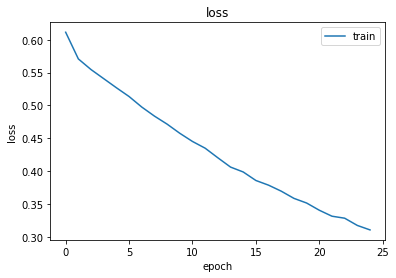

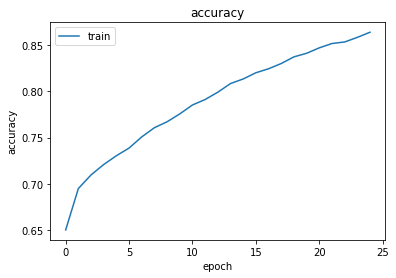

In [9]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'], label='train')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='train')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

##Make prediction

In [10]:
del train_tensor

test_tensor = generate_feature_tensor(features, test_triplets, training=False)

# Predict
test_y = model.predict(test_tensor)

# Create submission file
test_y_fixed = np.where(test_y < 0.5, 0, 1)

np.savetxt('submission.txt', test_y_fixed, fmt='%d')

100%|██████████| 59544/59544 [00:07<00:00, 7528.74it/s]
